## Content

1. [User Quafu cloud API](#User-Quafu-cloud-API)
2. [Initiate session](#Initiate-session)
3. [Methods](#Methods)
4. [QUBO coefficients](#QUBO-coefficients)
5. [QAOA ansatz](#QAOA-ansatz)
6. [Parameterized Quantum Circuit](#Parameterized-Quantum-Circuit)
7. [Results](#Results)

### User Quafu cloud API

In [1]:
token_api = ''

### Initiate session

In [2]:
from quafu import User
user = User(token_api)
user.save_apitoken()

### Methods

In [3]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from quafu import Task
from quafu import QuantumCircuit

### QUBO coefficients

In [4]:
qubits = [sp.Symbol("q1"), sp.Symbol("q2"), sp.Symbol("q3")]

p1, p2, p3 = 39.5, 3.6, 87.8
N = 100
asset_prices = [p1, p2, p3]
function = -N + p1 * qubits[0] + p2 * qubits[1] +  p3 * qubits[2]
    
square_function = function**2

In [5]:
qubo = square_function.expand()
qubo

1560.25*q1**2 + 284.4*q1*q2 + 6936.2*q1*q3 - 7900.0*q1 + 12.96*q2**2 + 632.16*q2*q3 - 720.0*q2 + 7708.84*q3**2 - 17560.0*q3 + 10000

In [6]:
def qubo_matrix(init_coeffs, cost_fun):
    
    nb_qb = len(init_coeffs)
    matrix = np.zeros((nb_qb, nb_qb))
    
    for i in range(nb_qb):
        
        matrix[i,i] = cost_fun.coeff(f"q{i + 1}**2") + cost_fun.coeff(f"q{i + 1}").args[0]
        
        for j in range(i + 1, nb_qb):
            
            matrix[i,j] = cost_fun.coeff(f"q{i + 1}*q{j + 1}")
            matrix[j,i] = cost_fun.coeff(f"q{i + 1}*q{j + 1}")
            
    return matrix

In [7]:
coeffs = qubo_matrix(asset_prices, qubo)
sp.Matrix(np.triu(coeffs))

Matrix([
[-6339.75,   284.4,   6936.2],
[       0, -707.04,   632.16],
[       0,       0, -9851.16]])

In [8]:
def gate_qubo_matrix(qubo_coeffs, qubo):
    
    nb_qb = len(qubo_coeffs)
    gate_coeffs = np.zeros((nb_qb, nb_qb))
    
    constant =  qubo.args[0]
    for i in range(nb_qb):
        
        constant += 0.5 * qubo_coeffs[i,i]
        
        gate_coeffs[i,i] = -0.5 * sum(qubo_coeffs[i])
        
        for j in range(i + 1, nb_qb):
            constant += 0.25 * qubo_coeffs[i,j]
            gate_coeffs[i,j] = qubo_coeffs[i,j] / 4
    
    return [gate_coeffs, constant]

In [9]:
gate_qubo = gate_qubo_matrix(coeffs, qubo)
sp.Matrix(gate_qubo[0])

Matrix([
[-440.425,    71.1, 1734.05],
[       0, -104.76,  158.04],
[       0,       0,  1141.4]])

### QAOA ansatz

In [10]:
def ansatz(param, coeffs, nb_qubits):
    
    pqc = QuantumCircuit(nb_qubits)
    
    for r in range(len(param)):
        x = param[r]
        
        if r == 0:
            for i in range(nb_qubits):
                pqc.h(i)

        pqc.barrier()

        for i in range(nb_qubits):
            pqc.rz(i, coeffs[i,i] * x[0])
            
        pqc.barrier()

        for i in range(nb_qubits):
            for j in range(i + 1, nb_qubits):
                pqc.rzz(i, j, -2 * x[0] * coeffs[i,j])
                pqc.rz(i, coeffs[i,j] * x[0])
                pqc.rz(j, coeffs[i,j] * x[0])

        pqc.barrier()
 
        for i in range(nb_qubits):
            pqc.rx(i, 2 * x[1])
    
        
    measures = list(range(nb_qubits))
    pqc.measure(measures)
    
    return pqc

### Parameterized Quantum Circuit

Optimal parameters obtained from qiskit.

In [11]:
x_fd = [[4.473e+00,  4.256e+00], [4.425e+00,  4.059e+00]]

In [12]:
x_ng = [[4.928e+00,  3.866e+00], [4.692e+00,  3.549e+00]]

In [13]:
nb_qubits =  3
qaoa_fd = ansatz(x_fd, gate_qubo[0], nb_qubits)

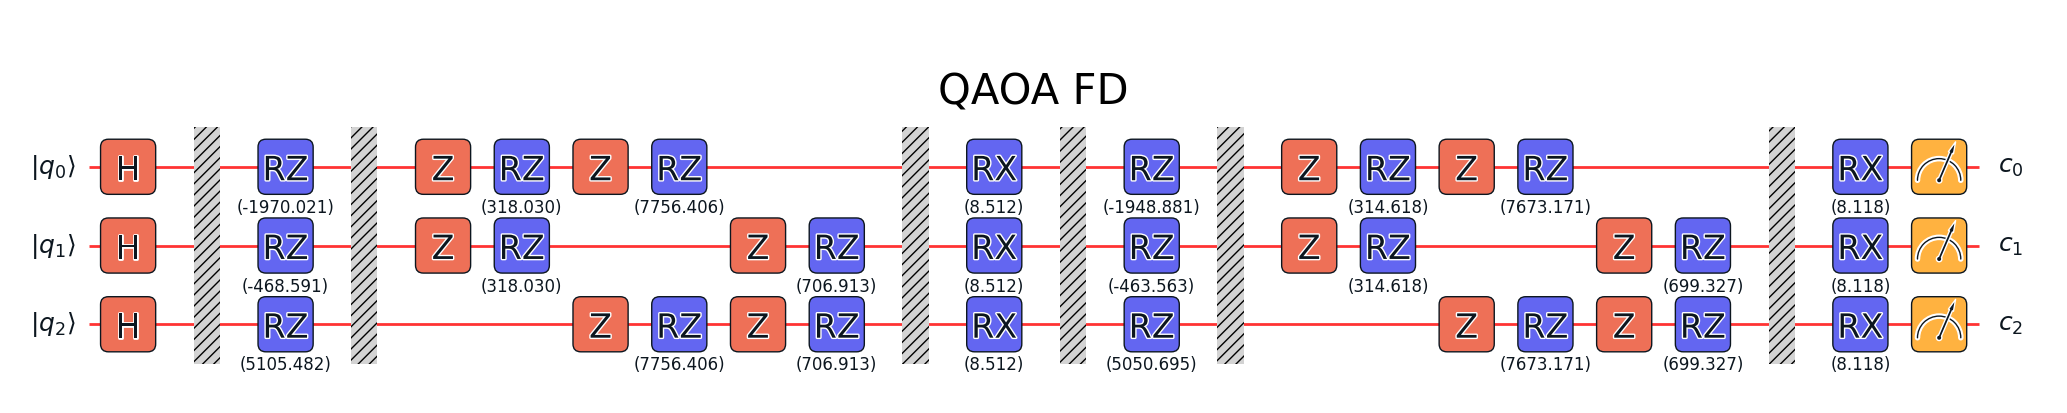

In [14]:
qaoa_fd.plot_circuit('QAOA FD')

In [15]:
nb_qubits = 3
qaoa_ng = ansatz(x_ng, gate_qubo[0], nb_qubits)

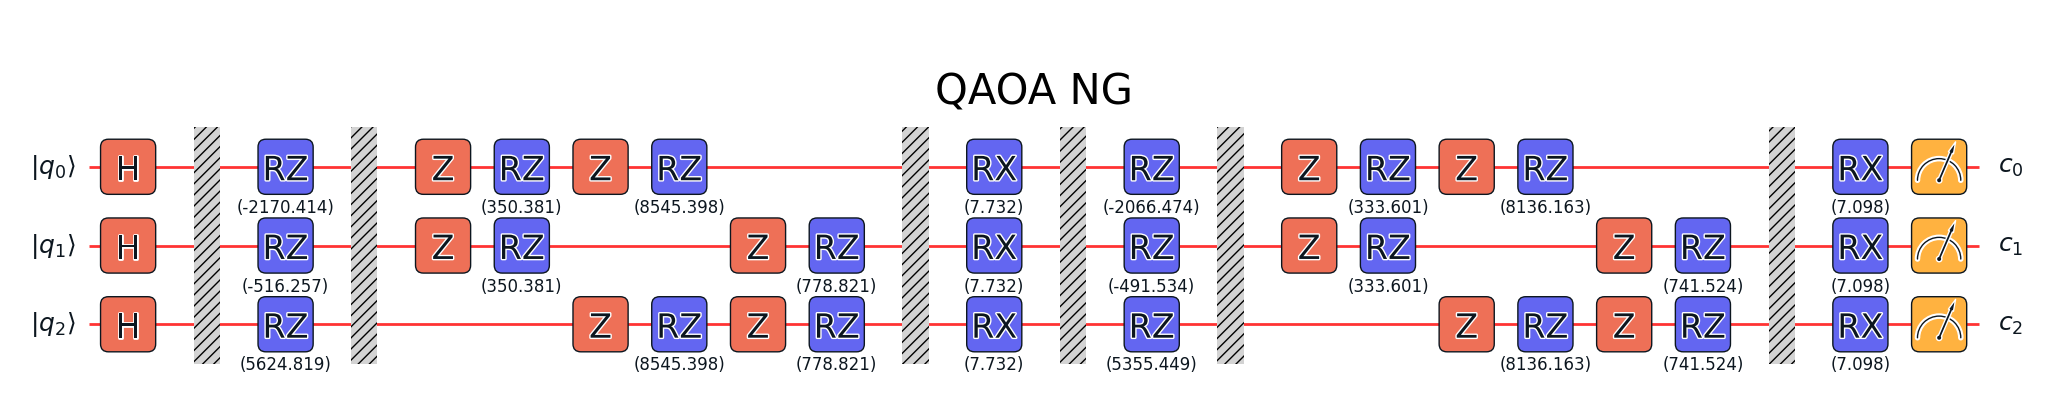

In [16]:
qaoa_ng.plot_circuit('QAOA NG')

### Results 

Quantum Processor Unit (QPU)

In [17]:
task = Task()

In [18]:
available_backends = user.get_available_backends()

system_name	 qubits	 status
ScQ-P10   	 10   	 Online
ScQ-P18   	 18   	 Online
ScQ-P136  	 136  	 Online
ScQ-P102  	 102  	 Maintenance
ScQ-P10C  	 10   	 Online
ScQ-XXX   	 2    	 Offline


In [27]:
backend_name = "ScQ-P18"

In [28]:
task.config(backend=f"{backend_name}", shots=1000, compile=True)

In [29]:
job_name = f"qaoa_fd_{backend_name}"

In [30]:
res_fd = task.send(qaoa_fd, name=job_name, wait=True)

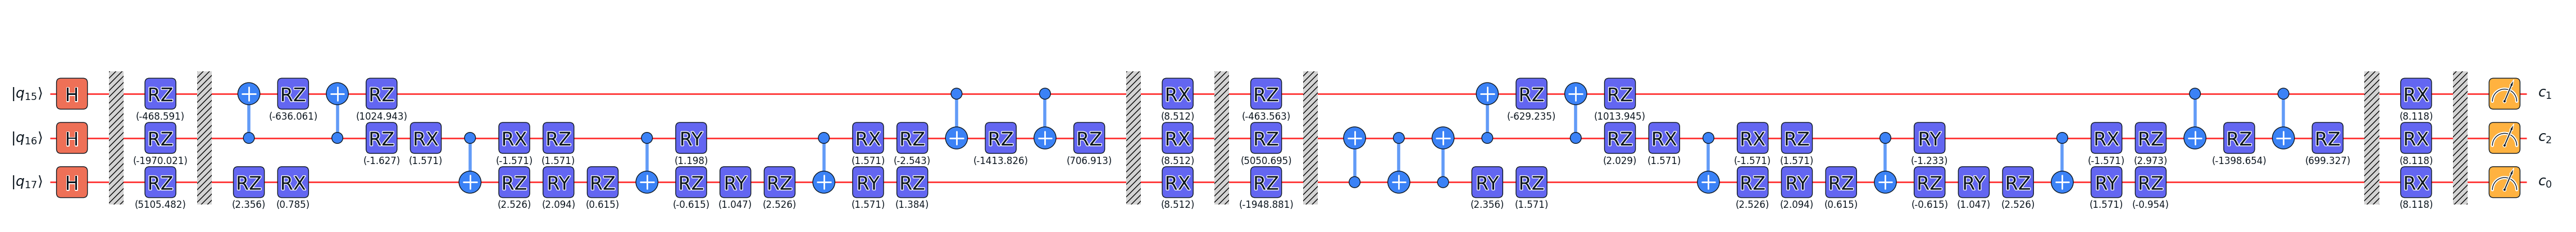

In [31]:
res_fd.transpiled_circuit.plot_circuit()

OrderedDict([('000', 126), ('001', 310), ('010', 67), ('011', 96), ('100', 126), ('101', 96), ('110', 69), ('111', 110)])


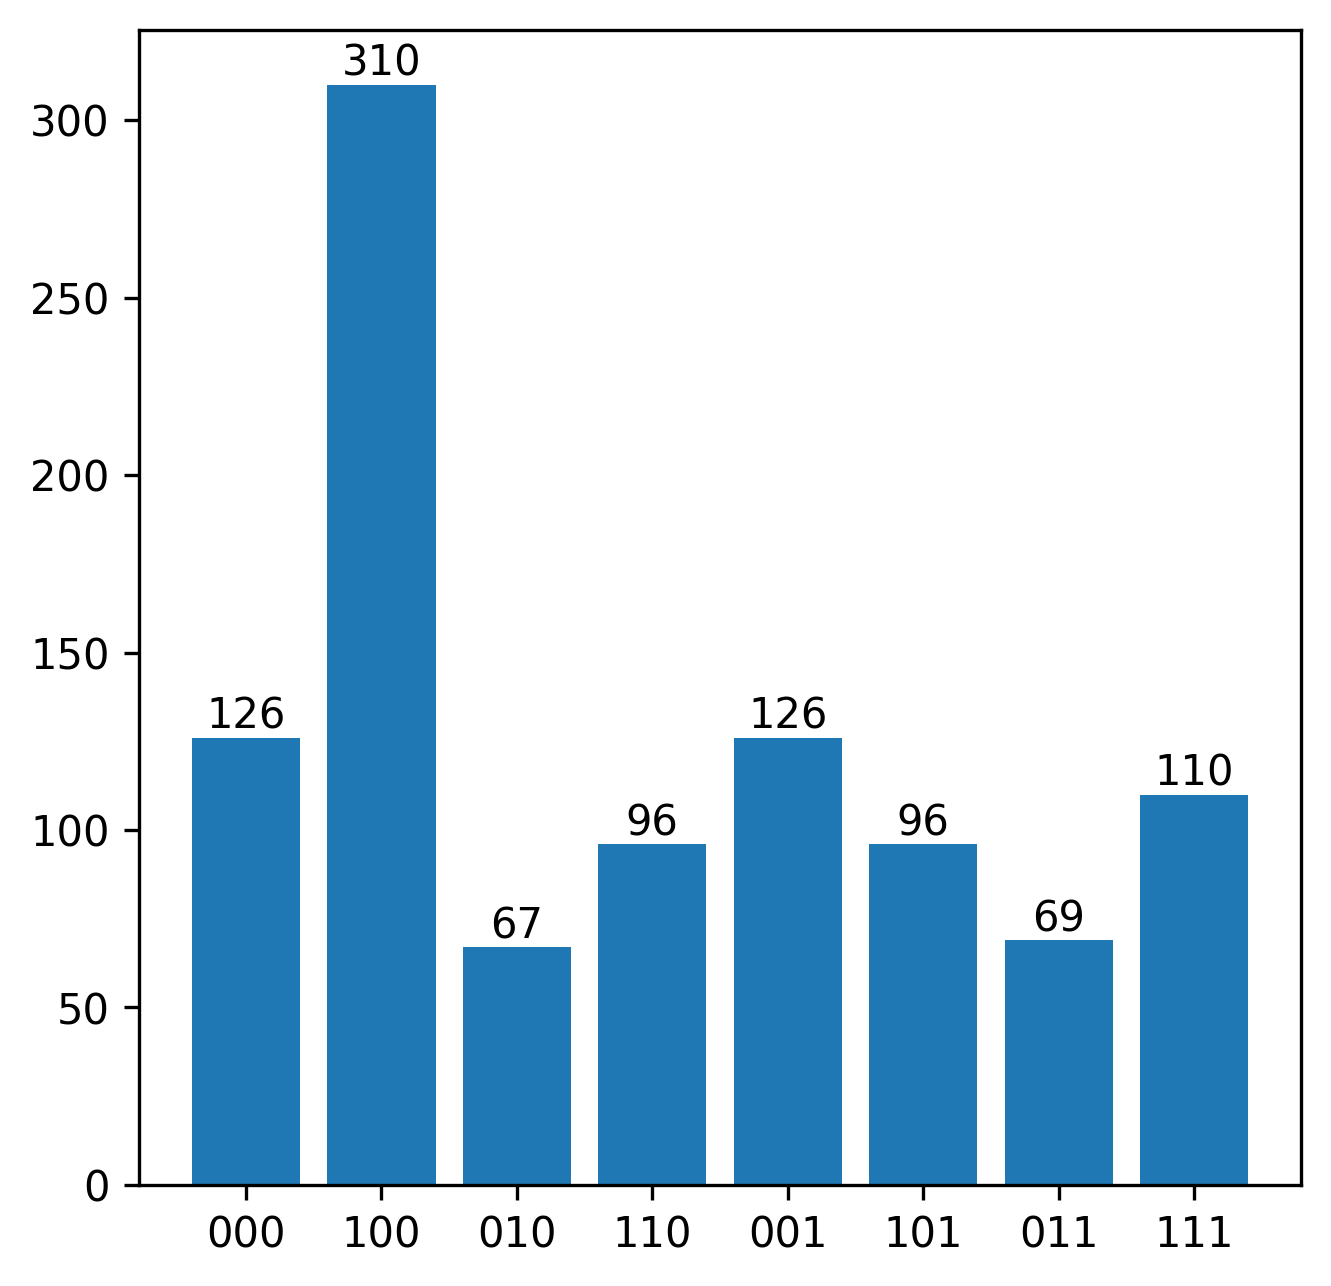

In [32]:
res_dict_fd = res_fd.counts
print(res_dict_fd)
plt.figure(figsize=(5,5), dpi=300)
little_endian = [s[::-1] for s in res_dict_fd.keys()]
counts = plt.bar(range(len(res_dict_fd)), list(res_dict_fd.values()), align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_fd)), list(little_endian))
plt.show()

In [33]:
job_name = f"qaoa_ng_{backend_name}"

In [34]:
res_ng = task.send(qaoa_ng, name=job_name, wait=True)

OrderedDict([('000', 106), ('001', 199), ('010', 95), ('011', 47), ('100', 116), ('101', 227), ('110', 65), ('111', 145)])


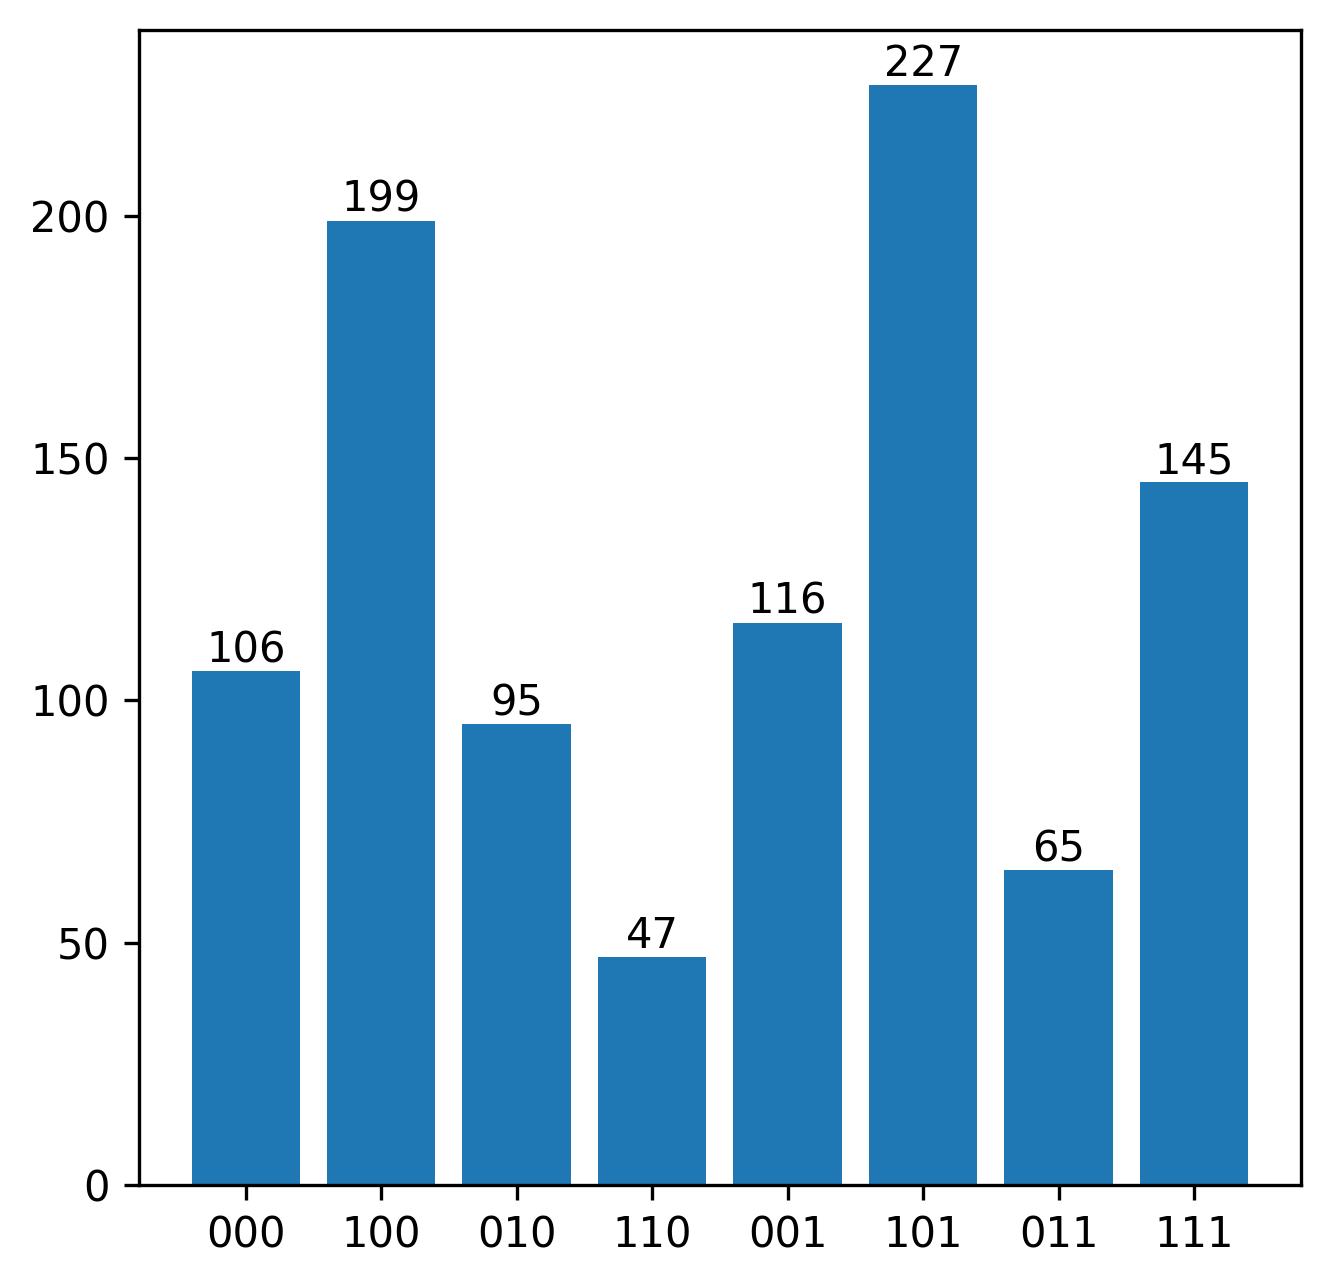

In [36]:
res_dict_ng = res_ng.counts
print(res_dict_ng)
plt.figure(figsize=(5,5), dpi=300)
little_endian = [s[::-1] for s in res_dict_ng.keys()]
counts = plt.bar(range(len(res_dict_ng)), list(res_dict_ng.values()), align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_ng)), list(little_endian))
plt.show()

### Other

In [37]:
available_backends = user.get_available_backends()

system_name	 qubits	 status
ScQ-P10   	 10   	 Online
ScQ-P18   	 18   	 Online
ScQ-P136  	 136  	 Online
ScQ-P102  	 102  	 Maintenance
ScQ-P10C  	 10   	 Online
ScQ-XXX   	 2    	 Offline


In [38]:
backend_name = "ScQ-P18"
task.config(backend=f"{backend_name}", shots=1000, compile=True)

OrderedDict([('000', 97), ('001', 359), ('010', 35), ('011', 107), ('100', 109), ('101', 79), ('110', 100), ('111', 114)])


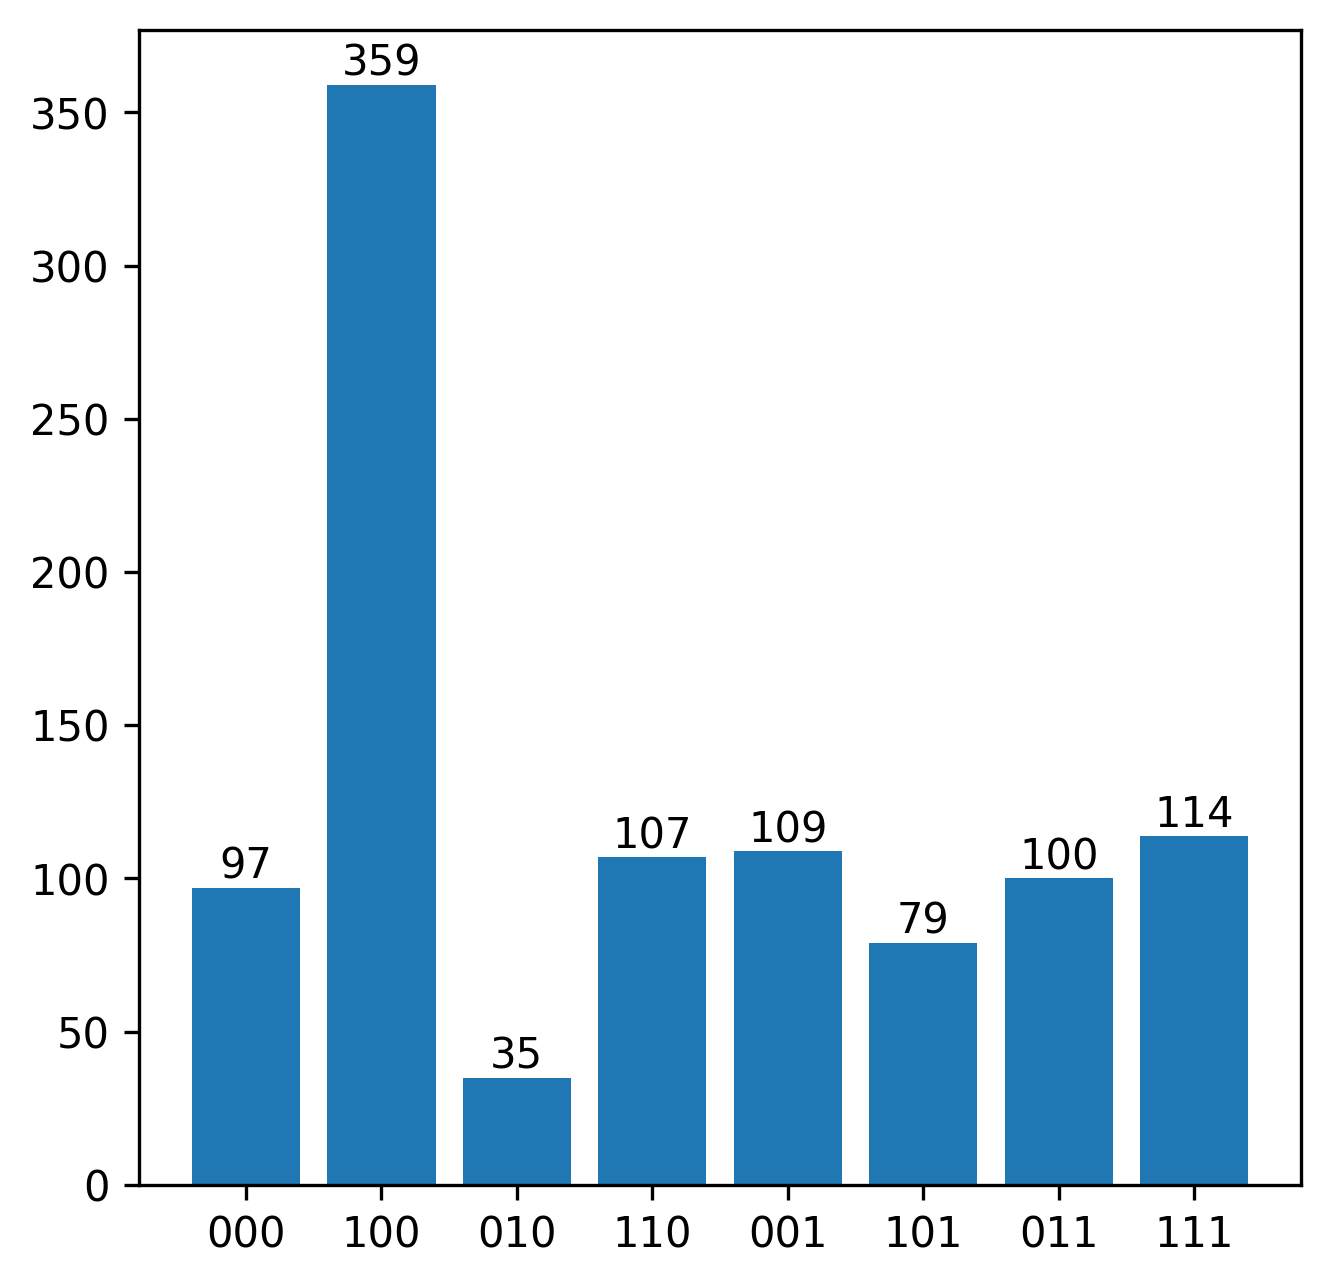

In [39]:
x_fd = [[4.473e+00,  4.256e+00], [4.425e+00,  4.059e+00]]
nb_qubits =  3
qaoa_fd = ansatz(x_fd, gate_qubo[0], nb_qubits)
job_name = f"qaoa_fd_{backend_name}"
res_fd = task.send(qaoa_fd, name=job_name, wait=True)
res_dict_fd = res_fd.counts
print(res_dict_fd)
plt.figure(figsize=(5,5), dpi=300)
little_endian = [s[::-1] for s in res_dict_fd.keys()]
counts = plt.bar(range(len(res_dict_fd)), list(res_dict_fd.values()), align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_fd)), list(little_endian))
plt.show()

OrderedDict([('000', 76), ('001', 175), ('010', 93), ('011', 36), ('100', 77), ('101', 265), ('110', 64), ('111', 214)])


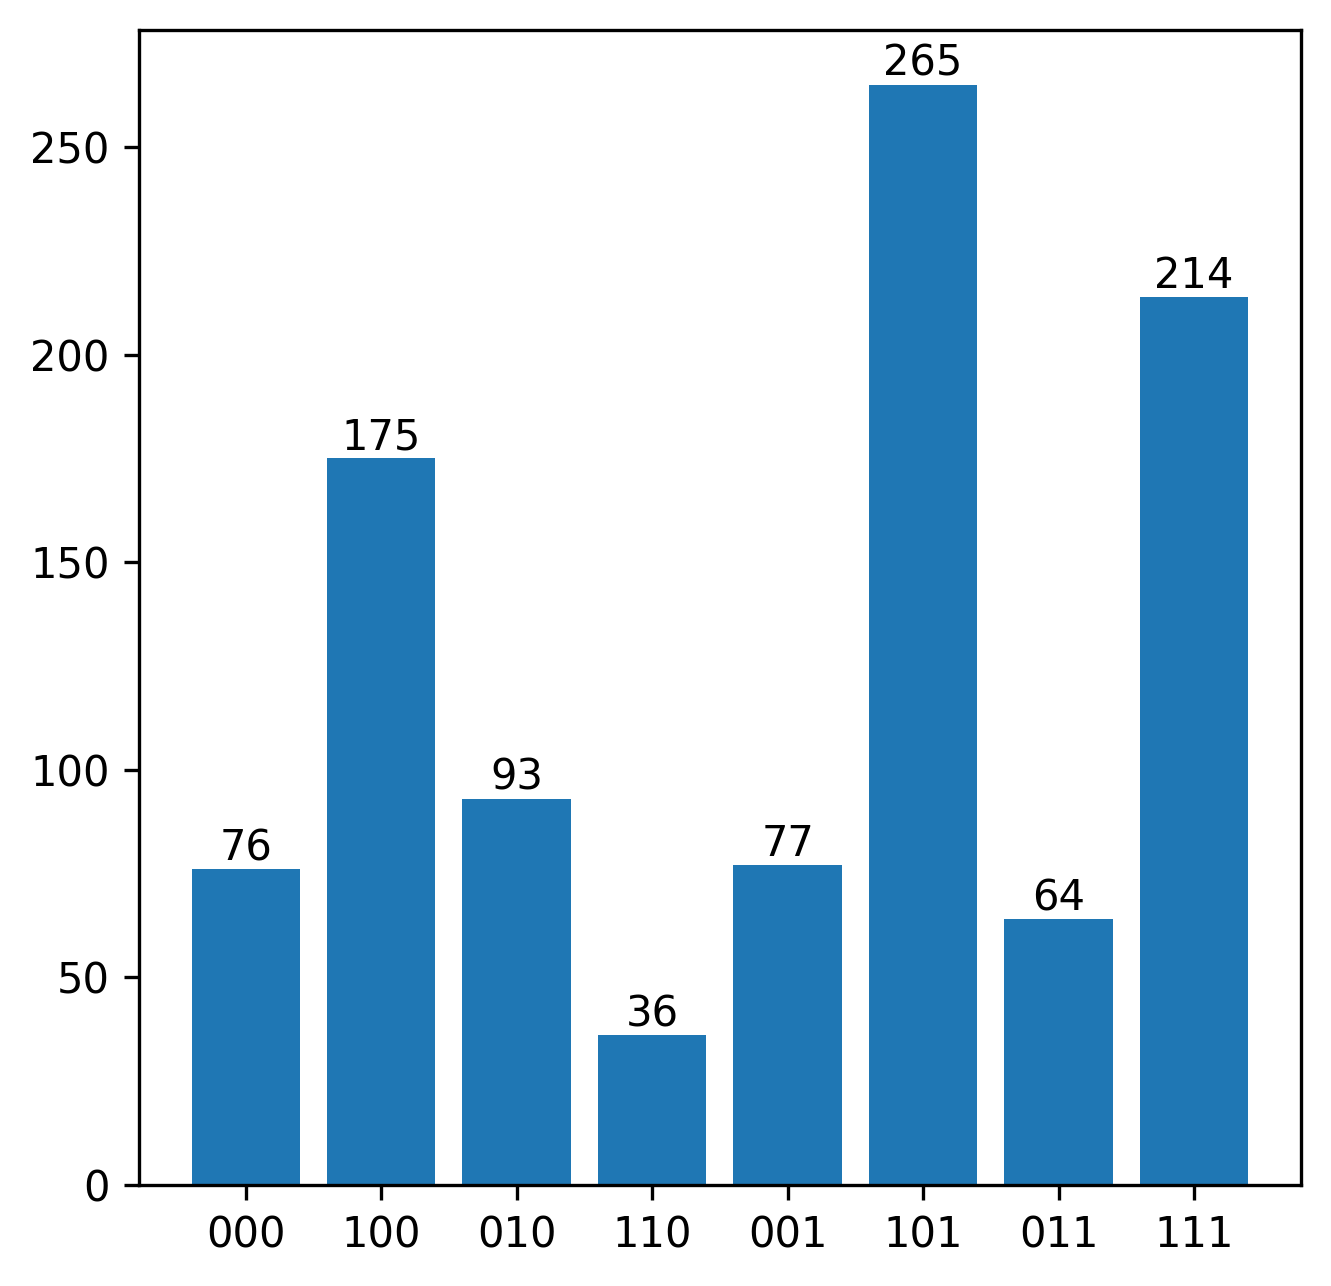

In [40]:
x_ng = [[4.928e+00,  3.866e+00], [4.692e+00,  3.549e+00]]
qaoa_ng = ansatz(x_ng, gate_qubo[0], nb_qubits)
job_name = f"qaoa_ng_{backend_name}"
res_ng = task.send(qaoa_ng, name=job_name, wait=True)
res_dict_ng = res_ng.counts
print(res_dict_ng)
plt.figure(figsize=(5,5), dpi=300)
little_endian = [s[::-1] for s in res_dict_ng.keys()]
counts = plt.bar(range(len(res_dict_ng)), list(res_dict_ng.values()), align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_ng)), list(little_endian))
plt.show()